In [1]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\Big_statistics\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [2]:
def variate_phase(F, phase_method,SNR=20,fs_mult=20,duration_T=30,window=10):
    phases = np.linspace(1,179,179)
    phases_kde = []

    for phase in phases:
        duration =duration_T/F
        fs = F *fs_mult

        t = np.linspace(0, duration, int(duration * fs))
        U = md.generate_sin(t, F, 2)
        I = md.generate_sin(t, F, 2, phase)

        noise_power = np.mean(U**2) / (10**(SNR / 10))
        noise = np.sqrt(noise_power) * np.random.randn(len(U))
        U += noise
        I += noise

        # Вызов метода напрямую
        time, phase_d = phase_method(t, U, I, F,window)
        phase_kde = md.get_kde_mode(phase_d)

        phases_kde.append(abs(phase_kde - phase))

    phase_min=min(phases_kde)
    phase_max=max(phases_kde)
    phase_kde_kde=md.get_kde_mode(phases_kde)

    return phase_min,phase_max,phase_kde_kde

In [3]:
def variate_methods(phase_methods,fs_mult=20,duration_T=30,window=10):

    F=440e3
    div_kdes=[]
    div_maxs=[]
    div_mins=[]
    for method in phase_methods:

        div_kde=[]
        div_max=[]
        div_min=[]
        SNR_range=range(10,60,5)

        for SNR in tqdm(SNR_range, desc=f"Метод {method.__name__}", unit=" шага"):
            phase_min,phase_max,phase_kde=variate_phase(F,method,SNR,fs_mult,duration_T,window)
            div_kde.append(phase_kde)
            div_max.append(phase_max)
            div_min.append(phase_min)

        div_kdes.append(div_kde)
        div_maxs.append(div_max)
        div_mins.append(div_min)

    return SNR_range,div_kdes

In [4]:
def clean_name(func):
    return func.__name__.replace("get_phase_", "").replace("get_phase", "")

def plot_methods_snr(SNR_range, div_kdes,phase_methods):
    fig = plt.figure(figsize=(6, 8))
    gs = fig.add_gridspec(2, 1)
    front = 12
    ax1 = fig.add_subplot(gs[0, 0])
    method_names = [clean_name(m) for m in phase_methods]
    
    for i in range(0,len(phase_methods),1):
        ax1.plot(SNR_range,div_kdes[i], label=method_names[i])

    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid()

    ax1.set_xlabel('SNR', fontsize=front)
    ax1.set_ylabel('Delta phase °', fontsize=front)

In [5]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]

In [6]:
SNR_range, div_kdes=variate_methods(phase_methods)

Метод get_phase_xcorr2: 100%|██████████| 10/10 [00:02<00:00,  4.88 шага/s]


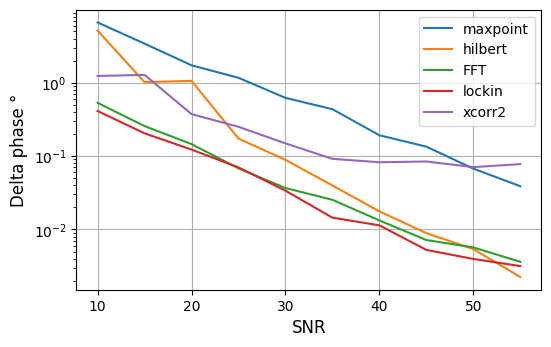

In [7]:
plot_methods_snr(SNR_range, div_kdes,phase_methods)

In [ ]:
owerall_mult=2
SNR_range, div_kdes=variate_methods(phase_methods,20*owerall_mult,30*owerall_mult,20*owerall_mult)
plot_methods_snr(SNR_range, div_kdes,phase_methods)

Метод get_phase_hilbert:  90%|█████████ | 9/10 [02:12<00:12, 12.84s/ шага]

Метод get_phase_xcorr2: 100%|██████████| 9/9 [00:01<00:00,  7.25 шага/s]


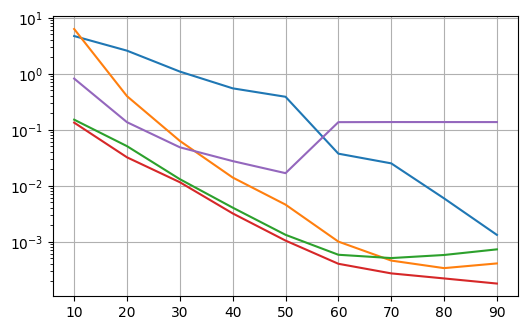

In [ ]:
owerall_mult=3
SNR_range, div_kdes=variate_methods(phase_methods,20*owerall_mult,30*owerall_mult,20*owerall_mult)
plot_methods_snr(SNR_range, div_kdes,phase_methods)

In [ ]:
owerall_mult=5
SNR_range, div_kdes=variate_methods(phase_methods,20*owerall_mult,30*owerall_mult,10*owerall_mult)
plot_methods_snr(SNR_range, div_kdes,phase_methods)

In [ ]:
def circular_mean_deg(phases_deg):
    phases_rad = np.deg2rad(phases_deg)
    mean_vec = np.mean(np.exp(1j*phases_rad))
    return np.rad2deg(np.angle(mean_vec))

0.003727368636715651


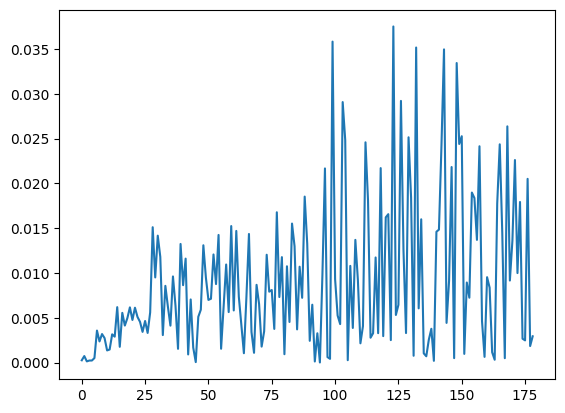

In [ ]:
phase_method=md.get_phase_hilbert
fs_mult,duration_T,window=40,120,60

SNR=40

phases = np.linspace(1,179,179)
phases_kde = []

for phase in phases:
    duration =duration_T/F
    fs = F *fs_mult
    t = np.linspace(0, duration, int(duration * fs))
    U = md.generate_sin(t, F, 2)
    I = md.generate_sin(t, F, 2, phase)
    noise_power = np.mean(U**2) / (10**(SNR / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(U))
    U += noise
    I += noise
    # Вызов метода напрямую
    time, phase_d = phase_method(t, U, I, F,window)
    phase_kde = circular_mean_deg(phase_d)
    phases_kde.append(abs(phase_kde - phase))

plt.plot(phases_kde)
print (md.get_kde_mode(phases_kde))

In [ ]:
import numpy as np

def snr_coherent(x, t, f0, window=None):
    """
    Когерентная оценка SNR.
    x   - сигнал (1D numpy), сигнал+шум
    t   - временные метки (same length)
    f0  - известная частота (Hz)
    window - None или window array same length as x (для уменьшения краевых эффектов)
    
    Метод:
      A = (2/N) * sum x[n] * exp(-j*2π f0 t[n])   -- оценка комплексной амплитуды
      s_hat = Re(A * exp(j*2π f0 t))              -- оценка синусоиды
      P_signal = mean(s_hat**2)
      P_noise  = mean((x - s_hat)**2)
      SNR = 10*log10(P_signal / P_noise)
    Возвращает (SNR_dB, A, P_signal, P_noise, s_hat)
    """
    x = np.asarray(x).astype(float)
    t = np.asarray(t).astype(float)
    N = len(x)
    if window is None:
        w = np.ones(N)
    else:
        w = np.asarray(window).astype(float)
        # нормируем окно по суммарной амплитуде, чтобы не менять уровень амплитуды
        w = w / np.mean(w)
    xw = x * w

    # вычислим комплексную амплитуду методом прямого интеграла (можно использовать свертку/DFT)
    expo = np.exp(-1j * 2.0 * np.pi * f0 * t)
    A = (2.0 / N) * np.sum(xw * expo)   # множитель 2/N даёт амплитудную нормировку, можно варьировать

    # реконструируем синусоиду
    s_hat = np.real(A * np.exp(1j * 2.0 * np.pi * f0 * t))

    P_signal = np.mean(s_hat**2)
    P_noise  = np.mean((x - s_hat)**2)
    if P_noise <= 0:
        SNR_dB = np.inf
    else:
        SNR_dB = 10.0 * np.log10(P_signal / P_noise)
    return SNR_dB, A, P_signal, P_noise, s_hat


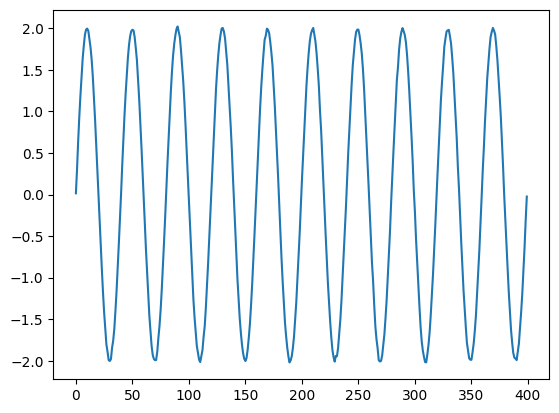

In [ ]:
phase_method=md.get_phase_hilbert
fs_mult,duration_T,window=40,10,60
SNR=40

duration =duration_T/F
fs = F *fs_mult
t = np.linspace(0, duration, int(duration * fs))
U = md.generate_sin(t, F, 2)
noise_power = np.mean(U**2) / (10**(SNR / 10))
noise = np.sqrt(noise_power) * np.random.randn(len(U))
U += noise
plt.plot(U)

In [ ]:
snr_coherent(U,t,F)

(np.float64(39.89041215504507),
 np.complex128(0.00035407003509867695-1.9971604905267075j),
 np.float64(1.9893392627687907),
 np.float64(0.00020401760204331897),
 array([ 3.54070035e-04,  3.13550966e-01,  6.18988529e-01,  9.09108203e-01,
         1.17673050e+00,  1.41523267e+00,  1.61871258e+00,  1.78213479e+00,
         1.90145514e+00,  1.97372086e+00,  1.99714362e+00,  1.97114378e+00,
         1.89636474e+00,  1.77465704e+00,  1.60903254e+00,  1.40358988e+00,
         1.16341309e+00,  8.94445728e-01,  6.03343837e-01,  2.97311210e-01,
        -1.60788708e-02, -3.29071054e-01, -6.33919833e-01, -9.23081224e-01,
        -1.18939945e+00, -1.42628404e+00, -1.62787288e+00, -1.78917734e+00,
        -1.90620566e+00, -1.97606179e+00, -1.99701702e+00, -1.96855279e+00,
        -1.89137348e+00, -1.76738903e+00, -1.59966763e+00, -1.39235983e+00,
        -1.15059580e+00, -8.80358380e-01, -5.88335049e-01, -2.81752400e-01,
         3.18026748e-02,  3.44570740e-01,  6.48811837e-01,  9.36997018e-01,
  